In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report


In [10]:
from google.colab import files
uploaded = files.upload()
df = pd.read_csv(next(iter(uploaded)))
df.head()



Saving stroop_data.csv to stroop_data (2).csv


,participant_id,accuracy_percent,avg_reaction_time_sec,notes_optional
0,P01,97.9,1.90,NaN
1,P02,96.5,1.60,NaN
2,P03,100.0,1.35,NaN
3,P04,98.5,1.32,NaN
4,P05,98.6,1.23,NaN


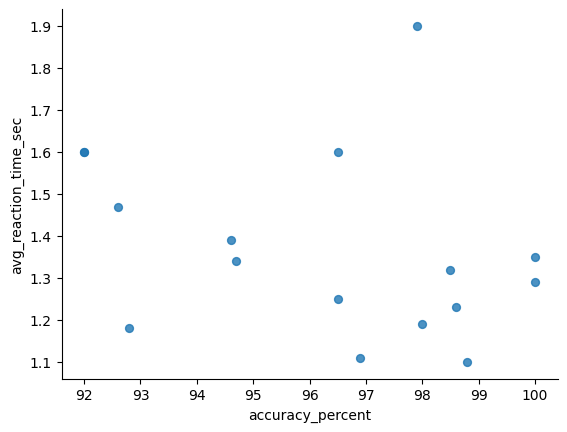

In [11]:
# @title accuracy_percent vs avg_reaction_time_sec

from matplotlib import pyplot as plt
df.plot(kind='scatter', x='accuracy_percent', y='avg_reaction_time_sec', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

In [3]:
# Convert reaction time to ms if needed
if "avg_reaction_time_sec" in df.columns:
    df["avg_reaction_time_ms"] = df["avg_reaction_time_sec"] * 1000

X = df[["avg_reaction_time_ms"]]  # Add "accuracy_percent" if available

# Scale features for clustering/SVM/DT
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [4]:
# Apply K-Means (3 clusters: Low, Medium, High)
kmeans = KMeans(n_clusters=3, random_state=0)
df["label"] = kmeans.fit_predict(X_scaled)

# Optional: sort cluster labels by reaction time to make Low=0, Medium=1, High=2
cluster_means = df.groupby("label")["avg_reaction_time_ms"].mean().sort_values()
label_mapping = {old_label: new_label for new_label, old_label in enumerate(cluster_means.index)}
df["label"] = df["label"].map(label_mapping)

print("Clustered labels:")
print(df[["avg_reaction_time_ms","label"]])
print(df["label"].value_counts())


Clustered labels:
    avg_reaction_time_ms  label
0                 1900.0      2
1                 1600.0      2
2                 1350.0      1
3                 1320.0      1
4                 1230.0      0
5                 1100.0      0
6                 1290.0      1
7                 1110.0      0
8                 1190.0      0
9                 1390.0      1
10                1600.0      2
11                1470.0      1
12                1180.0      0
13                1600.0      2
14                1250.0      0
15                1340.0      1
label
1    6
0    6
2    4
Name: count, dtype: int64


In [5]:
y = df["label"].values

# Stratify if all classes have ≥2 samples
min_samples = df["label"].value_counts().min()
stratify_param = y if min_samples >= 2 else None

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.25, random_state=42, stratify=stratify_param
)

print("Train labels:", np.unique(y_train, return_counts=True))
print("Test labels:", np.unique(y_test, return_counts=True))


Train labels: (array([0, 1, 2]), array([4, 5, 3]))
Test labels: (array([0, 1, 2]), array([2, 1, 1]))


In [6]:
svm_model = SVC(kernel='rbf', random_state=0)
svm_model.fit(X_train, y_train)
y_pred_svm = svm_model.predict(X_test)


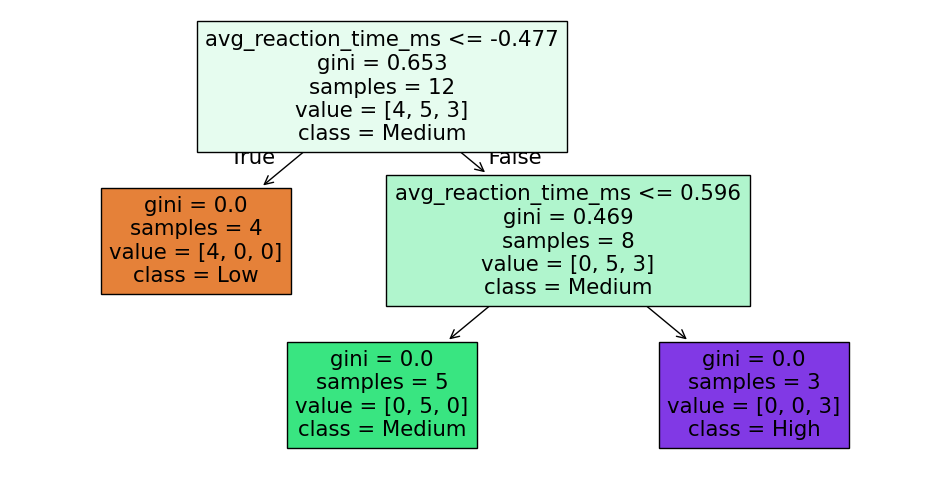

In [7]:
dt_model = DecisionTreeClassifier(random_state=0)
dt_model.fit(X_train, y_train)
y_pred_dt = dt_model.predict(X_test)

# Plot the tree
plt.figure(figsize=(12,6))
plot_tree(dt_model, feature_names=["avg_reaction_time_ms"], class_names=["Low","Medium","High"], filled=True)
plt.show()


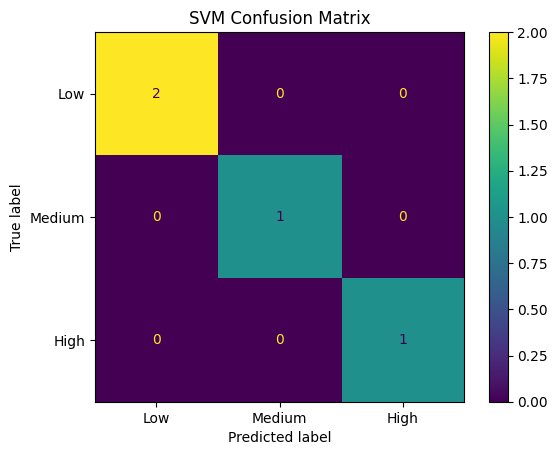

SVM Classification Report:

              precision    recall  f1-score   support

         Low       1.00      1.00      1.00         2
      Medium       1.00      1.00      1.00         1
        High       1.00      1.00      1.00         1

    accuracy                           1.00         4
   macro avg       1.00      1.00      1.00         4
weighted avg       1.00      1.00      1.00         4



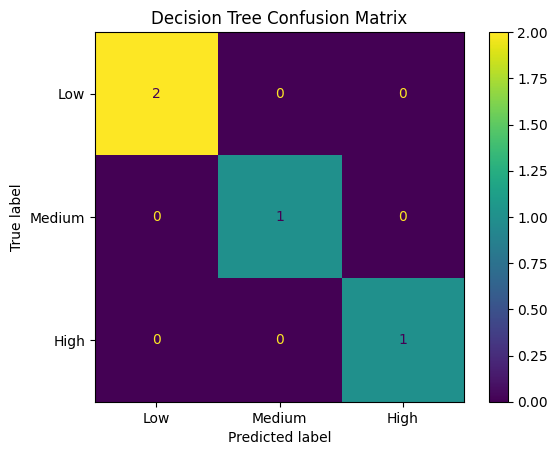

Decision Tree Classification Report:

              precision    recall  f1-score   support

         Low       1.00      1.00      1.00         2
      Medium       1.00      1.00      1.00         1
        High       1.00      1.00      1.00         1

    accuracy                           1.00         4
   macro avg       1.00      1.00      1.00         4
weighted avg       1.00      1.00      1.00         4



In [8]:
labels = [0,1,2]
label_names = ["Low","Medium","High"]

for model_name, y_pred in [("SVM", y_pred_svm), ("Decision Tree", y_pred_dt)]:
    cm = confusion_matrix(y_test, y_pred, labels=labels)
    ConfusionMatrixDisplay(cm, display_labels=label_names).plot()
    plt.title(f"{model_name} Confusion Matrix")
    plt.show()

    print(f"{model_name} Classification Report:\n")
    print(classification_report(y_test, y_pred, labels=labels, target_names=label_names, zero_division=0))
